We will start with CIFAR-10

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.transforms as transforms
import torchvision

# Data Augmentation and Normalization for CIFAR-10
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 170M/170M [00:16<00:00, 10.1MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Function to train, validate, and compute test accuracy for models (CNN/ViT)
def train_validate_test(model, trainloader, testloader, optimizer, criterion, epochs=10, is_vit=False, threshold=95.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    train_acc_history, val_acc_history, test_acc_history = [], [], []
    best_acc = 0
    threshold_epoch = None  # To track the first epoch where validation accuracy exceeds the threshold
    memory_allocated_history = []  # To track memory allocated per epoch

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        # Track initial memory usage at the start of each epoch
        if device == 'cuda':
            memory_allocated = torch.cuda.memory_allocated(device)
            memory_reserved = torch.cuda.memory_reserved(device)
            print(f'Epoch {epoch+1}: Initial Memory Allocated: {memory_allocated / (1024 ** 2):.2f} MB, '
                  f'Memory Reserved: {memory_reserved / (1024 ** 2):.2f} MB')

        # Training phase
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc_history.append(train_accuracy)
        train_loss = running_loss / len(trainloader)
        train_time = time.time() - start_time

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_acc_history.append(val_accuracy)
        val_loss = val_loss / len(testloader)

        # Track memory usage at the end of the epoch
        if device == 'cuda':
            memory_allocated = torch.cuda.memory_allocated(device)
            memory_reserved = torch.cuda.memory_reserved(device)
            print(f'Epoch {epoch+1}: Final Memory Allocated: {memory_allocated / (1024 ** 2):.2f} MB, '
                  f'Memory Reserved: {memory_reserved / (1024 ** 2):.2f} MB')
            memory_allocated_history.append(memory_allocated / (1024 ** 2))  # Store memory usage in MB

        # Check if validation accuracy reaches or exceeds the threshold
        if val_accuracy >= threshold and threshold_epoch is None:
            threshold_epoch = epoch + 1  # Record the first epoch when the threshold is reached
            print(f'Validation accuracy reached {threshold}% at epoch {threshold_epoch}')

        # Test accuracy calculation
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        test_acc_history.append(test_accuracy)

        # Print epoch results
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
              f'Test Acc: {test_accuracy:.2f}%, Training Time: {train_time:.2f}s')

        # Save the best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), f'best_model_{"vit" if is_vit else "cnn"}.pth')

    # After training, print when the threshold was first reached (if it was)
    if threshold_epoch is not None:
        print(f'Validation accuracy of {threshold}% was first reached at epoch {threshold_epoch}')
    else:
        print(f'Validation accuracy of {threshold}% was not reached during training.')

    return train_acc_history, val_acc_history, test_acc_history, memory_allocated_history



In [ ]:
from torchvision.models import resnet18
import torch.optim as optim
import torch.nn as nn

# Load ResNet18 model with pretrained weights
cnn_model = resnet18(weights='IMAGENET1K_V1')

# Freeze all layers except the fully connected layer
for param in cnn_model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (for 10 classes in CIFAR-10)
cnn_model.fc = nn.Linear(512, 10)

# Only the parameters of the last layer (fully connected) will be optimized
optimizer_cnn = optim.SGD(cnn_model.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Now you can train the model, and only the last layer will be updated.
train_acc_cnn, val_acc_cnn, test_acc_cnn, memory_allocated_history = train_validate_test(cnn_model, trainloader, testloader, optimizer_cnn, criterion, epochs=230, is_vit=False, threshold=95.0)





Epoch 1: Initial Memory Allocated: 42.71 MB, Memory Reserved: 64.00 MB
Epoch 1: Final Memory Allocated: 68.19 MB, Memory Reserved: 718.00 MB
Epoch 1/230, Train Loss: 0.8121, Train Acc: 72.08%, Val Loss: 0.6929, Val Acc: 76.38%, Test Acc: 76.38%, Training Time: 58.05s
Epoch 2: Initial Memory Allocated: 68.19 MB, Memory Reserved: 718.00 MB
Epoch 2: Final Memory Allocated: 68.19 MB, Memory Reserved: 718.00 MB
Epoch 2/230, Train Loss: 0.7179, Train Acc: 75.30%, Val Loss: 0.6669, Val Acc: 77.49%, Test Acc: 77.49%, Training Time: 56.73s
Epoch 3: Initial Memory Allocated: 68.19 MB, Memory Reserved: 718.00 MB
Epoch 3: Final Memory Allocated: 68.19 MB, Memory Reserved: 718.00 MB
Epoch 3/230, Train Loss: 0.6984, Train Acc: 76.02%, Val Loss: 0.6887, Val Acc: 77.20%, Test Acc: 77.20%, Training Time: 56.77s
Epoch 4: Initial Memory Allocated: 68.19 MB, Memory Reserved: 718.00 MB
Epoch 4: Final Memory Allocated: 68.19 MB, Memory Reserved: 718.00 MB
Epoch 4/230, Train Loss: 0.7028, Train Acc: 76.16%, 

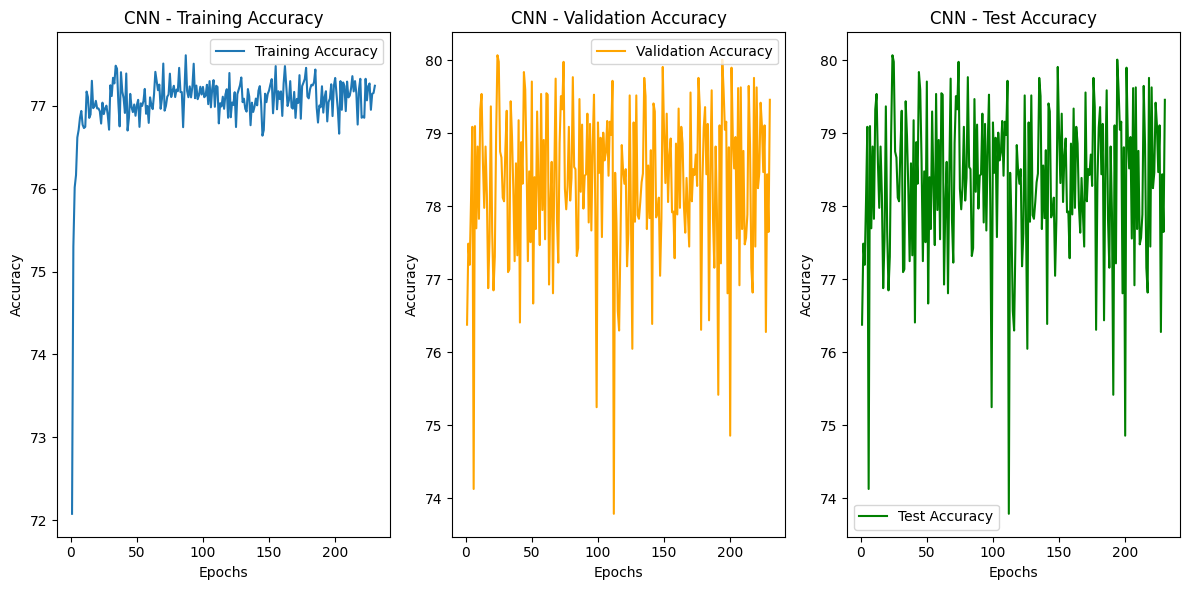

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, test_acc, model_name="Model"):
    epochs = len(train_acc)  # Total number of epochs

    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for CNN
plot_training_history(train_acc_cnn, val_acc_cnn, test_acc_cnn, model_name="CNN")




In [ ]:
pip install timm

In [ ]:
# prompt: import timm

import timm


In [ ]:
from timm import create_model
import torch.optim as optim

# ViT Model
vit_model = create_model('vit_base_patch16_224', pretrained=True, num_classes=10)

# Freeze all layers except the classification head
for param in vit_model.parameters():
    param.requires_grad = False

for param in vit_model.head.parameters():
    param.requires_grad = True

# Optimizer for ViT (fine-tuning only the last layer)
optimizer_vit = optim.AdamW(vit_model.head.parameters(), lr=3e-4, weight_decay=0.01)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train and Validate the ViT
train_acc_vit, val_acc_vit, test_acc_vit, memory_allocated_history = train_validate_test(vit_model, trainloader, testloader, optimizer_vit, criterion, epochs=13, is_vit=True, threshold=95.0)



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: Initial Memory Allocated: 327.33 MB, Memory Reserved: 382.00 MB
Epoch 1: Final Memory Allocated: 353.48 MB, Memory Reserved: 1130.00 MB
Epoch 1/16, Train Loss: 0.3354, Train Acc: 90.35%, Val Loss: 0.1773, Val Acc: 94.47%, Test Acc: 94.47%, Training Time: 546.92s
Epoch 2: Initial Memory Allocated: 353.48 MB, Memory Reserved: 1130.00 MB
Epoch 2: Final Memory Allocated: 353.48 MB, Memory Reserved: 1130.00 MB
Validation accuracy reached 95.0% at epoch 2
Epoch 2/16, Train Loss: 0.1744, Train Acc: 94.24%, Val Loss: 0.1574, Val Acc: 95.02%, Test Acc: 95.02%, Training Time: 550.48s
Epoch 3: Initial Memory Allocated: 353.48 MB, Memory Reserved: 1130.00 MB
Epoch 3: Final Memory Allocated: 353.48 MB, Memory Reserved: 1130.00 MB
Epoch 3/16, Train Loss: 0.1595, Train Acc: 94.74%, Val Loss: 0.1461, Val Acc: 95.23%, Test Acc: 95.23%, Training Time: 549.69s
Epoch 4: Initial Memory Allocated: 353.48 MB, Memory Reserved: 1130.00 MB
Epoch 4: Final Memory Allocated: 353.48 MB, Memory Reserved: 11

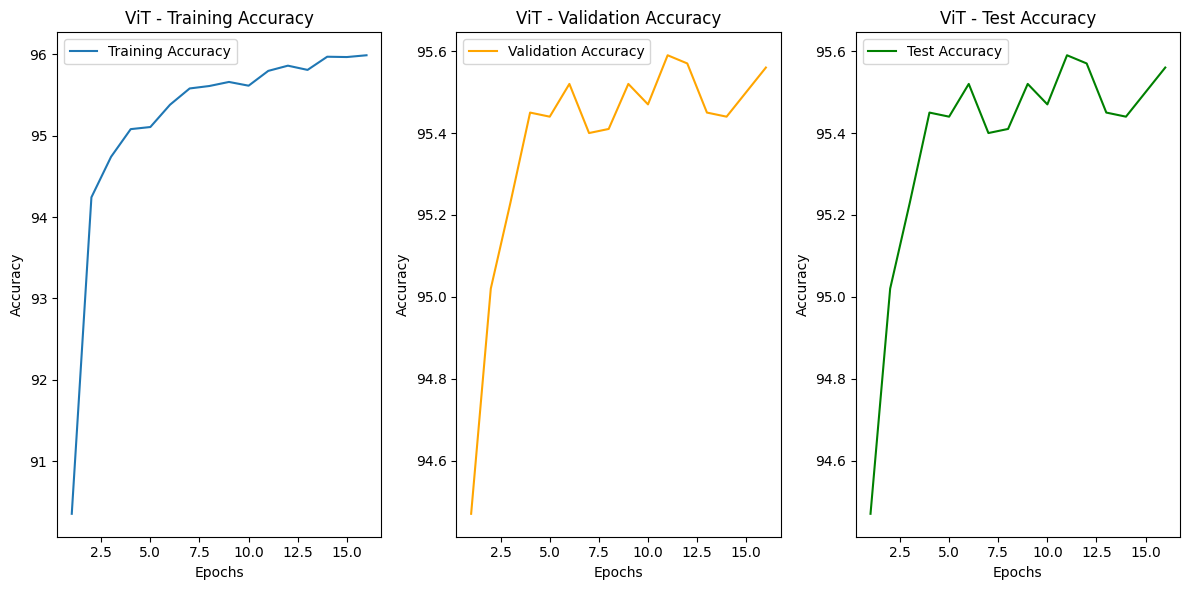

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, test_acc, model_name="Model"):
    epochs = len(train_acc)  # Total number of epochs

    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for ViT
plot_training_history(train_acc_vit, val_acc_vit, test_acc_vit, model_name="ViT")


Now lets do for CIFAR-100

In [ ]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
import torchvision.transforms as transforms
import torchvision

# Data Augmentation and Normalization for CIFAR-100
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))  # CIFAR-100 mean and std
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2761))  # CIFAR-100 mean and std
])

# Load CIFAR-100 dataset
trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


100%|██████████| 169M/169M [00:05<00:00, 29.4MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:

# Function to train, validate, and test the model (same as your original)
def train_validate_test(model, trainloader, testloader, optimizer, criterion, epochs=10, is_vit=False, threshold=95.0):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    train_acc_history, val_acc_history, test_acc_history = [], [], []
    best_acc = 0
    threshold_epoch = None  # To track the first epoch where validation accuracy exceeds the threshold
    memory_allocated_history = []  # To track memory allocated per epoch

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        start_time = time.time()

        # Track initial memory usage at the start of each epoch
        if device == 'cuda':
            memory_allocated = torch.cuda.memory_allocated(device)
            memory_reserved = torch.cuda.memory_reserved(device)
            print(f'Epoch {epoch+1}: Initial Memory Allocated: {memory_allocated / (1024 ** 2):.2f} MB, '
                  f'Memory Reserved: {memory_reserved / (1024 ** 2):.2f} MB')

        # Training phase
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc_history.append(train_accuracy)
        train_loss = running_loss / len(trainloader)
        train_time = time.time() - start_time

        # Validation phase
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_accuracy = 100 * val_correct / val_total
        val_acc_history.append(val_accuracy)
        val_loss = val_loss / len(testloader)

        # Track memory usage at the end of the epoch
      if device == 'cuda':
            memory_allocated = torch.cuda.memory_allocated(device)
            memory_reserved = torch.cuda.memory_reserved(device)
            print(f'Epoch {epoch+1}: Final Memory Allocated: {memory_allocated / (1024 ** 2):.2f} MB, '
                  f'Memory Reserved: {memory_reserved / (1024 ** 2):.2f} MB')
            memory_allocated_history.append(memory_allocated / (1024 ** 2))  # Store memory usage in MB

        # Check if validation accuracy reaches or exceeds the threshold
        if val_accuracy >= threshold and threshold_epoch is None:
            threshold_epoch = epoch + 1  # Record the first epoch when the threshold is reached
            print(f'Validation accuracy reached {threshold}% at epoch {threshold_epoch}')

        # Test accuracy calculation
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for inputs, labels in testloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = outputs.max(1)
                test_total += labels.size(0)
                test_correct += predicted.eq(labels).sum().item()

        test_accuracy = 100 * test_correct / test_total
        test_acc_history.append(test_accuracy)

        # Print epoch results
        print(f'Epoch {epoch+1}/{epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
              f'Test Acc: {test_accuracy:.2f}%, Training Time: {train_time:.2f}s')

        # Save the best model
        if val_accuracy > best_acc:
            best_acc = val_accuracy
            torch.save(model.state_dict(), f'best_model_{"vit" if is_vit else "cnn"}.pth')

    # After training, print when the threshold was first reached (if it was)
    if threshold_epoch is not None:
        print(f'Validation accuracy of {threshold}% was first reached at epoch {threshold_epoch}')
    else:
        print(f'Validation accuracy of {threshold}% was not reached during training.')

    return train_acc_history, val_acc_history, test_acc_history, memory_allocated_history


In [ ]:
from torchvision.models import resnet18
import torch.optim as optim
import torch.nn as nn

# Load ResNet18 model with pretrained weights
cnn_model = resnet18(weights='IMAGENET1K_V1')

# Freeze all layers except the fully connected layer
for param in cnn_model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (for 10 classes in CIFAR-10)
cnn_model.fc = nn.Linear(512, 100)

# Only the parameters of the last layer (fully connected) will be optimized
optimizer_cnn = optim.SGD(cnn_model.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Define loss function
criterion = nn.CrossEntropyLoss()


# Now you can train the model, and only the last layer will be updated.
train_acc_cnn, val_acc_cnn, test_acc_cnn, memory_allocated_history = train_validate_test(cnn_model, trainloader, testloader, optimizer_cnn, criterion, epochs=200, is_vit=False, threshold=95.0)





Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:02<00:00, 16.6MB/s]


Epoch 1: Initial Memory Allocated: 42.88 MB, Memory Reserved: 64.00 MB
Epoch 1: Final Memory Allocated: 68.72 MB, Memory Reserved: 718.00 MB
Epoch 1/200, Train Loss: 2.4238, Train Acc: 40.10%, Val Loss: 1.8226, Val Acc: 51.00%, Test Acc: 51.00%, Training Time: 57.25s
Epoch 2: Initial Memory Allocated: 68.72 MB, Memory Reserved: 718.00 MB
Epoch 2: Final Memory Allocated: 68.72 MB, Memory Reserved: 718.00 MB
Epoch 2/200, Train Loss: 1.7890, Train Acc: 51.84%, Val Loss: 1.7129, Val Acc: 53.53%, Test Acc: 53.53%, Training Time: 56.15s
Epoch 3: Initial Memory Allocated: 68.72 MB, Memory Reserved: 718.00 MB
Epoch 3: Final Memory Allocated: 68.72 MB, Memory Reserved: 718.00 MB
Epoch 3/200, Train Loss: 1.6835, Train Acc: 54.03%, Val Loss: 1.6601, Val Acc: 54.63%, Test Acc: 54.63%, Training Time: 56.04s
Epoch 4: Initial Memory Allocated: 68.72 MB, Memory Reserved: 718.00 MB
Epoch 4: Final Memory Allocated: 68.72 MB, Memory Reserved: 940.00 MB
Epoch 4/200, Train Loss: 1.6389, Train Acc: 55.20%, 

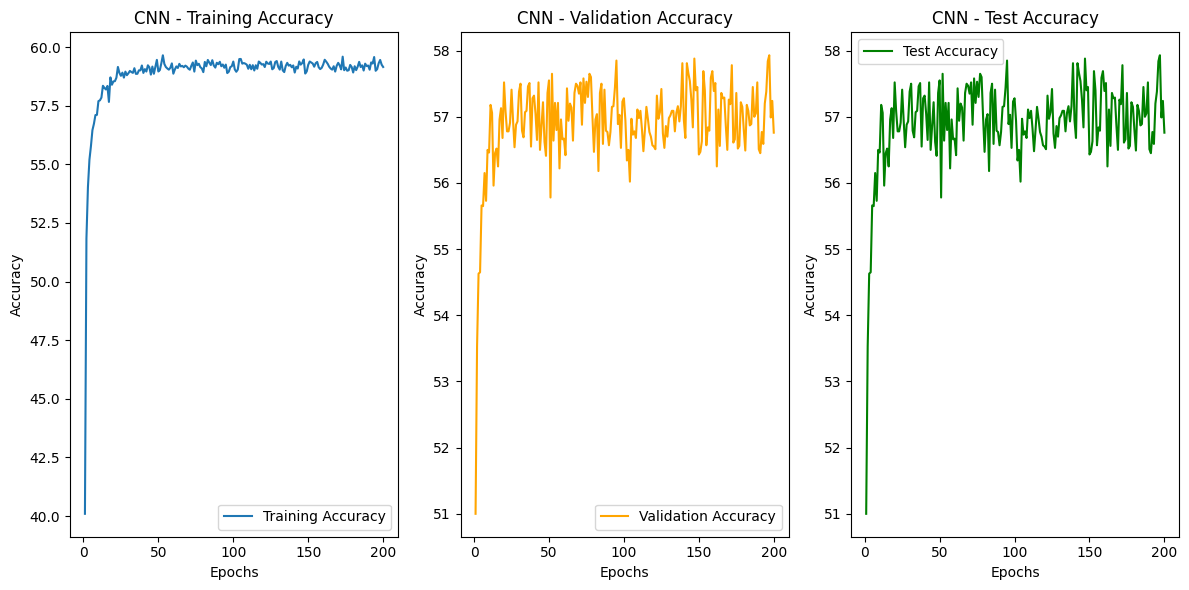

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, test_acc, model_name="Model"):
    epochs = len(train_acc)  # Total number of epochs

    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for CNN
plot_training_history(train_acc_cnn, val_acc_cnn, test_acc_cnn, model_name="CNN")

In [ ]:
pip install timm

In [ ]:
%env CUDA_LAUNCH_BLOCKING=1


env: CUDA_LAUNCH_BLOCKING=1


In [ ]:
from timm import create_model
import torch.optim as optim

# ViT Model
vit_model = create_model('vit_base_patch16_224', pretrained=True, num_classes=100)

# Freeze all layers except the classification head
for param in vit_model.parameters():
    param.requires_grad = False

for param in vit_model.head.parameters():
    param.requires_grad = True

# Optimizer for ViT (fine-tuning only the last layer)
optimizer_vit = optim.AdamW(vit_model.head.parameters(), lr=3e-4, weight_decay=0.01)

# Loss function
criterion = nn.CrossEntropyLoss()

# Train and Validate the ViT
train_acc_vit, val_acc_vit, test_acc_vit, memory_allocated_history = train_validate_test(vit_model, trainloader, testloader, optimizer_vit, criterion, epochs=13, is_vit=True, threshold=95.0)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: Initial Memory Allocated: 327.59 MB, Memory Reserved: 382.00 MB
Epoch 1: Final Memory Allocated: 354.54 MB, Memory Reserved: 1130.00 MB
Epoch 1/13, Train Loss: 1.2955, Train Acc: 69.68%, Val Loss: 0.6992, Val Acc: 80.65%, Test Acc: 80.65%, Training Time: 578.38s
Epoch 2: Initial Memory Allocated: 354.54 MB, Memory Reserved: 1130.00 MB
Epoch 2: Final Memory Allocated: 354.54 MB, Memory Reserved: 1130.00 MB
Epoch 2/13, Train Loss: 0.6959, Train Acc: 80.22%, Val Loss: 0.6277, Val Acc: 82.13%, Test Acc: 82.13%, Training Time: 585.54s
Epoch 3: Initial Memory Allocated: 354.54 MB, Memory Reserved: 1130.00 MB
Epoch 3: Final Memory Allocated: 354.54 MB, Memory Reserved: 1130.00 MB
Epoch 3/13, Train Loss: 0.6118, Train Acc: 82.27%, Val Loss: 0.6018, Val Acc: 82.72%, Test Acc: 82.72%, Training Time: 585.74s
Epoch 4: Initial Memory Allocated: 354.54 MB, Memory Reserved: 1130.00 MB
Epoch 4: Final Memory Allocated: 354.54 MB, Memory Reserved: 1130.00 MB
Epoch 4/13, Train Loss: 0.5634, Trai

In [ ]:
print(vit_model.head)


Linear(in_features=768, out_features=100, bias=True)


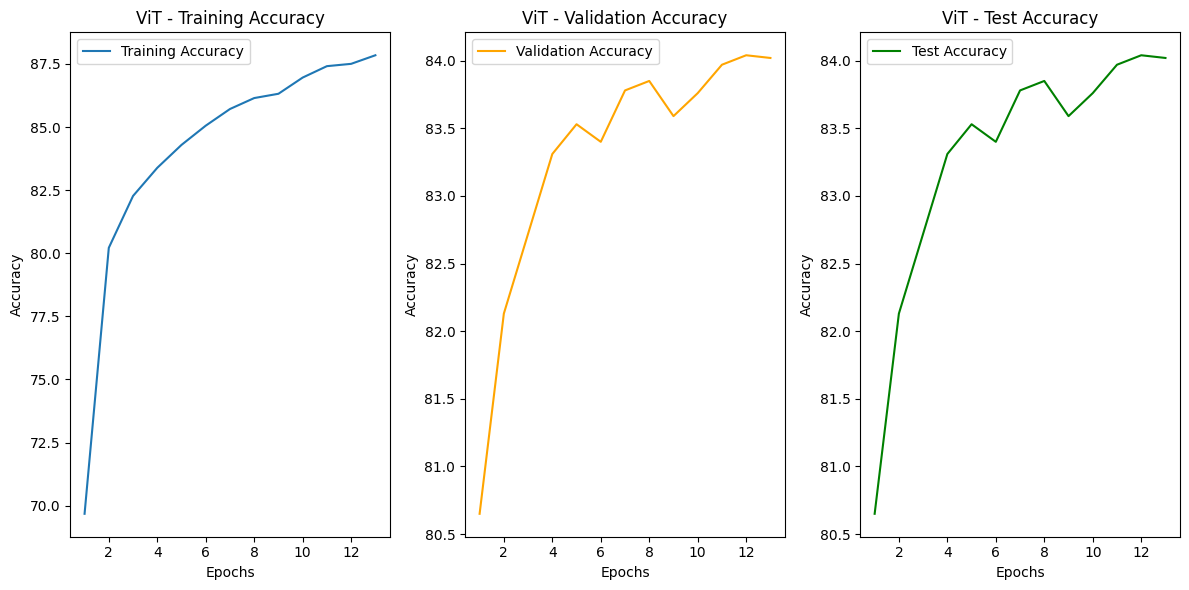

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, test_acc, model_name="Model"):
    epochs = len(train_acc)  # Total number of epochs

    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot for ViT
plot_training_history(train_acc_vit, val_acc_vit, test_acc_vit, model_name="ViT")

Oxford-IIIT pets dataset


In [ ]:
from google.colab import drive
import os
import tarfile

# Mount Google Drive
drive.mount('/content/drive')

# Paths to the files in Google Drive
images_tar_path = '/content/drive/MyDrive/images.tar.gz'
annotations_tar_path = '/content/drive/MyDrive/annotations.tar.gz'

# Extract paths
extract_path = '/content/dataset'
os.makedirs(extract_path, exist_ok=True)

# Extract images.tar.gz
with tarfile.open(images_tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

# Extract annotations.tar.gz
with tarfile.open(annotations_tar_path, 'r:gz') as tar:
    tar.extractall(path=extract_path)

print(f"Dataset extracted to: {extract_path}")


Mounted at /content/drive
Dataset extracted to: /content/dataset


In [ ]:
import os

# Check the directory structure
for root, dirs, files in os.walk(extract_path):
    print(f"Root: {root}, Dirs: {dirs}, Files: {files[:5]}")  # Print only first 5 files in each directory


Root: /content/dataset, Dirs: ['images', 'annotations'], Files: []
Root: /content/dataset/images, Dirs: [], Files: ['Bengal_143.jpg', 'miniature_pinscher_21.jpg', 'english_cocker_spaniel_94.jpg', 'Russian_Blue_84.jpg', 'Sphynx_59.jpg']
Root: /content/dataset/annotations, Dirs: ['trimaps', 'xmls'], Files: ['list.txt', 'README', 'trainval.txt', '._trimaps', 'test.txt']
Root: /content/dataset/annotations/trimaps, Dirs: [], Files: ['._american_bulldog_3.png', 'great_pyrenees_29.png', 'leonberger_130.png', '._British_Shorthair_59.png', 'Ragdoll_193.png']
Root: /content/dataset/annotations/xmls, Dirs: [], Files: ['yorkshire_terrier_171.xml', 'english_setter_104.xml', 'beagle_133.xml', 'Abyssinian_190.xml', 'keeshond_165.xml']


In [ ]:
import os
import shutil  # Import shutil to use file operations

# Paths
images_path = '/content/dataset/images'
trainval_file = '/content/dataset/annotations/trainval.txt'
test_file = '/content/dataset/annotations/test.txt'
train_dir = '/content/dataset/train'
val_dir = '/content/dataset/val'

# Create train/val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Paths
images_path = '/content/dataset/images'
trainval_file = '/content/dataset/annotations/trainval.txt'
test_file = '/content/dataset/annotations/test.txt'
train_dir = '/content/dataset/train'
val_dir = '/content/dataset/val'

# Create train/val directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Function to organize images
def organize_images(file_path, dest_dir):
    with open(file_path, 'r') as f:
        for line in f:
            # Split the line and extract only the first two values
            fields = line.strip().split()
            image_name, class_id = fields[0], fields[1]  # Use only the first two fields
            class_dir = os.path.join(dest_dir, class_id)
            os.makedirs(class_dir, exist_ok=True)
            src_image_path = os.path.join(images_path, f"{image_name}.jpg")
            dest_image_path = os.path.join(class_dir, f"{image_name}.jpg")
            if os.path.exists(src_image_path):  # Move only if the file exists
                shutil.move(src_image_path, dest_image_path)

# Organize training and validation sets
organize_images(trainval_file, train_dir)
organize_images(test_file, val_dir)

print("Images organized successfully!")


Images organized successfully!


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")


Number of training samples: 3680
Number of validation samples: 3669


In [ ]:
import time

def train_validate_test(model, train_loader, val_loader, optimizer, criterion, epochs, is_vit, threshold=95.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_acc_history = []
    val_acc_history = []
    test_acc_history = []
    memory_allocated_history = []
    threshold_epoch = None

    best_val_acc = 0.0

    for epoch in range(epochs):
        start_time = time.time()  # Track the start time of the epoch

        # Training phase
        model.train()
        train_correct, train_total = 0, 0
        running_loss = 0.0

        # Track memory usage at the start of the epoch
        if device.type == 'cuda':
            memory_allocated = torch.cuda.memory_allocated(device)
            memory_reserved = torch.cuda.memory_reserved(device)
            print(f"Epoch {epoch + 1}: Initial Memory Allocated: {memory_allocated / (1024 ** 2):.2f} MB, "
                  f"Memory Reserved: {memory_reserved / (1024 ** 2):.2f} MB")

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            train_total += labels.size(0)
            train_correct += preds.eq(labels).sum().item()

        train_acc = 100 * train_correct / train_total
        train_acc_history.append(train_acc)

        # Validation phase
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                val_total += labels.size(0)
                val_correct += preds.eq(labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_acc_history.append(val_acc)

        # Test phase (using the validation loader as an example)
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:  # Replace with test_loader if separate test set is available
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                test_total += labels.size(0)
                test_correct += preds.eq(labels).sum().item()

        test_acc = 100 * test_correct / test_total
        test_acc_history.append(test_acc)

        # Memory tracking at the end of the epoch
        if device.type == 'cuda':
            memory_allocated = torch.cuda.memory_allocated(device)
            memory_reserved = torch.cuda.memory_reserved(device)
            print(f"Epoch {epoch + 1}: Final Memory Allocated: {memory_allocated / (1024 ** 2):.2f} MB, "
                  f"Memory Reserved: {memory_reserved / (1024 ** 2):.2f} MB")
            memory_allocated_history.append(memory_allocated / (1024 ** 2))

        # Calculate training time
        epoch_time = time.time() - start_time

        # Print epoch results
        print(f"Epoch {epoch + 1}/{epochs}: "
              f"Train Acc: {train_acc:.2f}%, "
              f"Val Acc: {val_acc:.2f}%, "
              f"Test Acc: {test_acc:.2f}%, "
              f"Loss: {running_loss:.4f}, "
              f"Training Time: {epoch_time:.2f}s")

        # Check if validation accuracy exceeds the threshold
        if val_acc >= threshold and threshold_epoch is None:
            threshold_epoch = epoch + 1
            print(f"Threshold of {threshold}% reached at epoch {threshold_epoch}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{'vit' if is_vit else 'cnn'}.pth")

    # Print threshold summary
    if threshold_epoch is not None:
        print(f"Validation accuracy of {threshold}% was first reached at epoch {threshold_epoch}")
    else:
        print(f"Validation accuracy of {threshold}% was not reached during training.")

    return train_acc_history, val_acc_history, test_acc_history, memory_allocated_history


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18

# Load ResNet18 model with pretrained weights
cnn_model = resnet18(weights='IMAGENET1K_V1')

# Freeze all layers except the fully connected layer
for param in cnn_model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer (for 37 classes in Oxford-IIIT Pets)
cnn_model.fc = nn.Linear(512, 37)  # Adjust for 37 classes

# Only the parameters of the last layer (fully connected) will be optimized
optimizer_cnn = optim.SGD(cnn_model.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Ensure train_validate_test function is defined (including the torch import inside that script)
# Train the model
train_acc_cnn, val_acc_cnn,test_acc_cnn, memory_allocated_history = train_validate_test(
    cnn_model, train_loader, val_loader, optimizer_cnn, criterion, epochs=200, is_vit=False, threshold=95.0
)


Epoch 1: Initial Memory Allocated: 595.09 MB, Memory Reserved: 1356.00 MB
Epoch 1: Final Memory Allocated: 607.30 MB, Memory Reserved: 1356.00 MB
Epoch 1/200: Train Acc: 58.67%, Val Acc: 81.58%, Test Acc: 81.41%, Loss: 97.1346, Training Time: 63.78s
Epoch 2: Initial Memory Allocated: 607.30 MB, Memory Reserved: 1356.00 MB
Epoch 2: Final Memory Allocated: 607.30 MB, Memory Reserved: 1356.00 MB
Epoch 2/200: Train Acc: 87.72%, Val Acc: 85.72%, Test Acc: 85.94%, Loss: 29.0851, Training Time: 63.10s
Epoch 3: Initial Memory Allocated: 607.30 MB, Memory Reserved: 1356.00 MB
Epoch 3: Final Memory Allocated: 607.30 MB, Memory Reserved: 1356.00 MB
Epoch 3/200: Train Acc: 90.30%, Val Acc: 86.89%, Test Acc: 87.22%, Loss: 22.1870, Training Time: 63.57s
Epoch 4: Initial Memory Allocated: 607.30 MB, Memory Reserved: 1356.00 MB
Epoch 4: Final Memory Allocated: 607.30 MB, Memory Reserved: 1356.00 MB
Epoch 4/200: Train Acc: 92.26%, Val Acc: 85.88%, Test Acc: 86.32%, Loss: 18.6939, Training Time: 62.97s


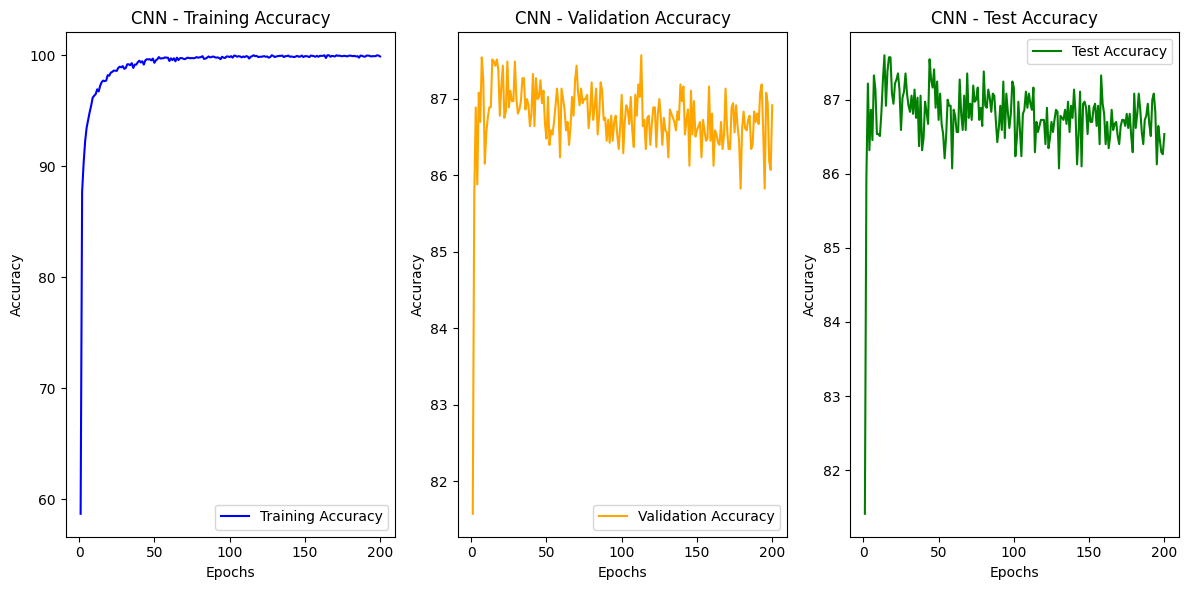

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc,test_acc, model_name="Model"):
    epochs = len(train_acc)  # Total number of epochs

    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming train_acc_cnn, val_acc_cnn, test_acc_cnn and train_acc_vit, val_acc_vit, test_acc_vit are available

# Plot for CNN
plot_training_history(train_acc_cnn, val_acc_cnn,test_acc_cnn, model_name="CNN")



In [ ]:
from timm import create_model

# Load Vision Transformer (ViT) model
vit_model = create_model('vit_base_patch16_224', pretrained=True, num_classes=37)

# Freeze all layers except the classification head
for param in vit_model.parameters():
    param.requires_grad = False

for param in vit_model.head.parameters():
    param.requires_grad = True

# Optimizer and loss function
optimizer_vit = optim.AdamW(vit_model.head.parameters(), lr=3e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Train the ViT
train_acc_vit, val_acc_vit,test_acc_vit,  memory_allocated_history_vit = train_validate_test(
    vit_model, train_loader, val_loader, optimizer_vit, criterion, epochs=12, is_vit=True, threshold=90.0
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch 1: Initial Memory Allocated: 681.77 MB, Memory Reserved: 1356.00 MB
Epoch 1: Final Memory Allocated: 694.16 MB, Memory Reserved: 1504.00 MB
Epoch 1/12: Train Acc: 57.07%, Val Acc: 85.25%, Test Acc: 85.36%, Loss: 108.7844, Training Time: 160.99s
Epoch 2: Initial Memory Allocated: 694.16 MB, Memory Reserved: 1504.00 MB
Epoch 2: Final Memory Allocated: 694.16 MB, Memory Reserved: 1504.00 MB
Epoch 2/12: Train Acc: 89.92%, Val Acc: 89.37%, Test Acc: 89.48%, Loss: 30.1160, Training Time: 162.50s
Epoch 3: Initial Memory Allocated: 694.16 MB, Memory Reserved: 1504.00 MB
Epoch 3: Final Memory Allocated: 694.16 MB, Memory Reserved: 1504.00 MB
Epoch 3/12: Train Acc: 93.86%, Val Acc: 90.35%, Test Acc: 90.22%, Loss: 18.9004, Training Time: 161.78s
Threshold of 90.0% reached at epoch 3
Epoch 4: Initial Memory Allocated: 694.16 MB, Memory Reserved: 1504.00 MB
Epoch 4: Final Memory Allocated: 694.16 MB, Memory Reserved: 1504.00 MB
Epoch 4/12: Train Acc: 95.19%, Val Acc: 91.36%, Test Acc: 91.28%,

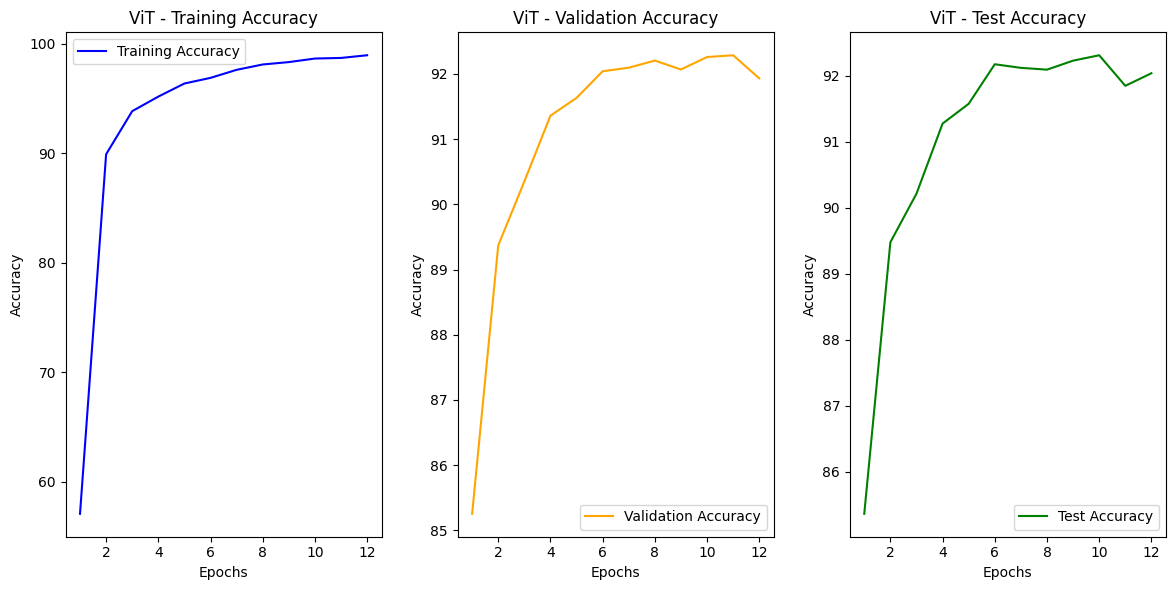

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, test_acc, model_name="Model"):
    epochs = len(train_acc)  # Total number of epochs

    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming train_acc_cnn, val_acc_cnn, test_acc_cnn and train_acc_vit, val_acc_vit, test_acc_vit are available



# Plot for ViT
plot_training_history(train_acc_vit, val_acc_vit, test_acc_vit, model_name="ViT")


Oxford Flowers-102

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define the path to the zip file and extraction directory
zip_file_path = '/content/drive/MyDrive/archive (4).zip'  # Update with your actual path
extract_path = '/content/oxford_flowers_dataset'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Dataset extracted to: {extract_path}")

# Define paths to train, validation, and test directories
train_dir = os.path.join(extract_path, 'dataset', 'train')
valid_dir = os.path.join(extract_path, 'dataset', 'valid')
test_dir = os.path.join(extract_path, 'dataset', 'test')

print(f"Train Directory: {train_dir}")
print(f"Validation Directory: {valid_dir}")
print(f"Test Directory: {test_dir}")


Dataset extracted to: /content/oxford_flowers_dataset
Train Directory: /content/oxford_flowers_dataset/dataset/train
Validation Directory: /content/oxford_flowers_dataset/dataset/valid
Test Directory: /content/oxford_flowers_dataset/dataset/test


In [ ]:
import os

test_dir = '/content/oxford_flowers_dataset/dataset/test'

# Check the contents of the test directory
print("Contents of test directory:", os.listdir(test_dir))


Contents of test directory: ['image_04012.jpg', 'image_07709.jpg', 'image_04555.jpg', 'image_03026.jpg', 'image_03830.jpg', 'image_05033.jpg', 'image_00990.jpg', 'image_06954.jpg', 'image_01512.jpg', 'image_02370.jpg', 'image_03538.jpg', 'image_06014.jpg', 'image_07361.jpg', 'image_01993.jpg', 'image_04910.jpg', 'image_04912.jpg', 'image_07902.jpg', 'image_04512.jpg', 'image_02472.jpg', 'image_01061.jpg', 'image_03488.jpg', 'image_07519.jpg', 'image_05277.jpg', 'image_03593.jpg', 'image_01307.jpg', 'image_05270.jpg', 'image_07468.jpg', 'image_01077.jpg', 'image_04400.jpg', 'image_06752.jpg', 'image_07352.jpg', 'image_07117.jpg', 'image_00092.jpg', 'image_06805.jpg', 'image_02041.jpg', 'image_00779.jpg', 'image_03968.jpg', 'image_06134.jpg', 'image_06104.jpg', 'image_06320.jpg', 'image_00319.jpg', 'image_03347.jpg', 'image_07551.jpg', 'image_05640.jpg', 'image_00970.jpg', 'image_05636.jpg', 'image_00833.jpg', 'image_04083.jpg', 'image_00365.jpg', 'image_07833.jpg', 'image_03985.jpg', 'i

In [ ]:
import os
import shutil

def organize_images_by_filename(test_dir, dest_dir):
    for image_file in os.listdir(test_dir):
        if image_file.endswith(".jpg"):
            # Example logic: extract the class name from the filename
            # Modify this based on your filename pattern
            class_name = image_file.split("_")[0]  # Assuming 'class1_image001.jpg'
            class_dir = os.path.join(dest_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)

            # Move the image to the class-specific folder
            shutil.move(os.path.join(test_dir, image_file), os.path.join(class_dir, image_file))

# Example usage
test_dir = '/content/oxford_flowers_dataset/dataset/test'
dest_dir = '/content/oxford_flowers_dataset/dataset/test_reorganized'
organize_images_by_filename(test_dir, dest_dir)


In [ ]:
import os
import json
import shutil
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define paths
dataset_dir = '/content/oxford_flowers_dataset'
train_dir = os.path.join(extract_path, 'dataset', 'train')
valid_dir = os.path.join(extract_path, 'dataset', 'valid')
test_dir = os.path.join(extract_path, 'dataset', 'test_reorganized')
# Load class names from JSON file
with open(os.path.join(dataset_dir, "cat_to_name.json"), "r") as f:
    class_names = json.load(f)

print("Class Names Loaded:", class_names)

# Verify dataset structure
if not os.path.exists(train_dir) or not os.path.exists(valid_dir) or not os.path.exists(test_dir):
    print("Organizing dataset into train/valid/test...")

    # Define function to reorganize images into subfolders
    def organize_images(src_dir, dest_dir, mapping):
        os.makedirs(dest_dir, exist_ok=True)
        for image_name, class_id in mapping.items():
            class_dir = os.path.join(dest_dir, str(class_id))
            os.makedirs(class_dir, exist_ok=True)
            src_path = os.path.join(src_dir, image_name)
            dest_path = os.path.join(class_dir, image_name)
            if os.path.exists(src_path):
                shutil.move(src_path, dest_path)

    # Example usage: Organize dataset (Update paths as needed)
    # organize_images(raw_test_dir, test_dir, mapping_from_file)

# Define transformations
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_valid_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
valid_dataset = datasets.ImageFolder(root=valid_dir, transform=transform_valid_test)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform_valid_test)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Dataset information
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")


Class Names Loaded: {'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pock

In [ ]:
import torch
import time

def train_validate_test(model, train_loader, val_loader, test_loader, optimizer, criterion, epochs, is_vit, threshold=95.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Metrics storage
    train_acc_history = []
    val_acc_history = []
    test_acc_history = []
    memory_allocated_history = []
    threshold_epoch = None

    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        train_correct, train_total = 0, 0
        running_loss = 0.0
        start_time = time.time()

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = outputs.max(1)
            train_total += labels.size(0)
            train_correct += preds.eq(labels).sum().item()

        train_acc = 100 * train_correct / train_total
        train_acc_history.append(train_acc)

        # Validation loop
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                val_total += labels.size(0)
                val_correct += preds.eq(labels).sum().item()

        val_acc = 100 * val_correct / val_total
        val_acc_history.append(val_acc)

        # Test loop
        test_correct, test_total = 0, 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                test_total += labels.size(0)
                test_correct += preds.eq(labels).sum().item()

        test_acc = 100 * test_correct / test_total
        test_acc_history.append(test_acc)

        # Track memory usage
        if device.type == 'cuda':
            memory_allocated = torch.cuda.memory_allocated(device)
            memory_reserved = torch.cuda.memory_reserved(device)
            memory_allocated_history.append(memory_allocated / (1024 ** 2))  # Convert to MB
            print(f"Epoch {epoch+1}: Memory Allocated: {memory_allocated / (1024 ** 2):.2f} MB, "
                  f"Memory Reserved: {memory_reserved / (1024 ** 2):.2f} MB")

        # Print epoch results
        end_time = time.time()
        print(f"Epoch {epoch + 1}/{epochs}: "
              f"Train Acc: {train_acc:.2f}%, "
              f"Val Acc: {val_acc:.2f}%, "
              f"Test Acc: {test_acc:.2f}%, "
              f"Loss: {running_loss:.4f}, "
              f"Time: {end_time - start_time:.2f}s")

        # Check if validation accuracy exceeds the threshold
        if val_acc >= threshold and threshold_epoch is None:
            threshold_epoch = epoch + 1
            print(f"Threshold of {threshold}% reached at epoch {threshold_epoch}")

        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_model_{'vit' if is_vit else 'cnn'}.pth")

    print("Training Completed.")
    return train_acc_history, val_acc_history, test_acc_history, memory_allocated_history


In [ ]:
from torchvision.models import resnet18
import torch.nn as nn
import torch.optim as optim

# Load CNN (ResNet18) model
cnn_model = resnet18(weights='IMAGENET1K_V1')

# Freeze all layers except the fully connected layer
for param in cnn_model.parameters():
    param.requires_grad = False

cnn_model.fc = nn.Linear(512, len(train_dataset.classes))  # Adjust for Oxford Flowers classes (102)

# Optimizer and Loss Function
optimizer_cnn = optim.SGD(cnn_model.fc.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

# Train CNN
# Train CNN
train_acc_cnn, val_acc_cnn, test_acc_cnn, memory_allocated_history_cnn = train_validate_test(
    cnn_model, train_loader, valid_loader, test_loader, optimizer_cnn, criterion, epochs=200, is_vit=False, threshold=95.0
)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]


Epoch 1: Memory Allocated: 70.46 MB, Memory Reserved: 394.00 MB
Epoch 1/200: Train Acc: 50.92%, Val Acc: 77.38%, Test Acc: 0.12%, Loss: 484.6759, Time: 59.54s
Epoch 2: Memory Allocated: 70.46 MB, Memory Reserved: 394.00 MB
Epoch 2/200: Train Acc: 78.72%, Val Acc: 83.37%, Test Acc: 1.22%, Loss: 201.0913, Time: 56.47s
Epoch 3: Memory Allocated: 70.46 MB, Memory Reserved: 394.00 MB
Epoch 3/200: Train Acc: 84.13%, Val Acc: 87.41%, Test Acc: 0.61%, Loss: 145.2869, Time: 57.01s
Epoch 4: Memory Allocated: 70.46 MB, Memory Reserved: 506.00 MB
Epoch 4/200: Train Acc: 85.52%, Val Acc: 88.14%, Test Acc: 0.61%, Loss: 128.6637, Time: 57.42s
Epoch 5: Memory Allocated: 70.46 MB, Memory Reserved: 506.00 MB
Epoch 5/200: Train Acc: 86.14%, Val Acc: 89.73%, Test Acc: 0.49%, Loss: 115.4122, Time: 56.74s
Epoch 6: Memory Allocated: 70.46 MB, Memory Reserved: 506.00 MB
Epoch 6/200: Train Acc: 87.26%, Val Acc: 89.12%, Test Acc: 0.61%, Loss: 106.7085, Time: 56.29s
Epoch 7: Memory Allocated: 70.46 MB, Memory Re

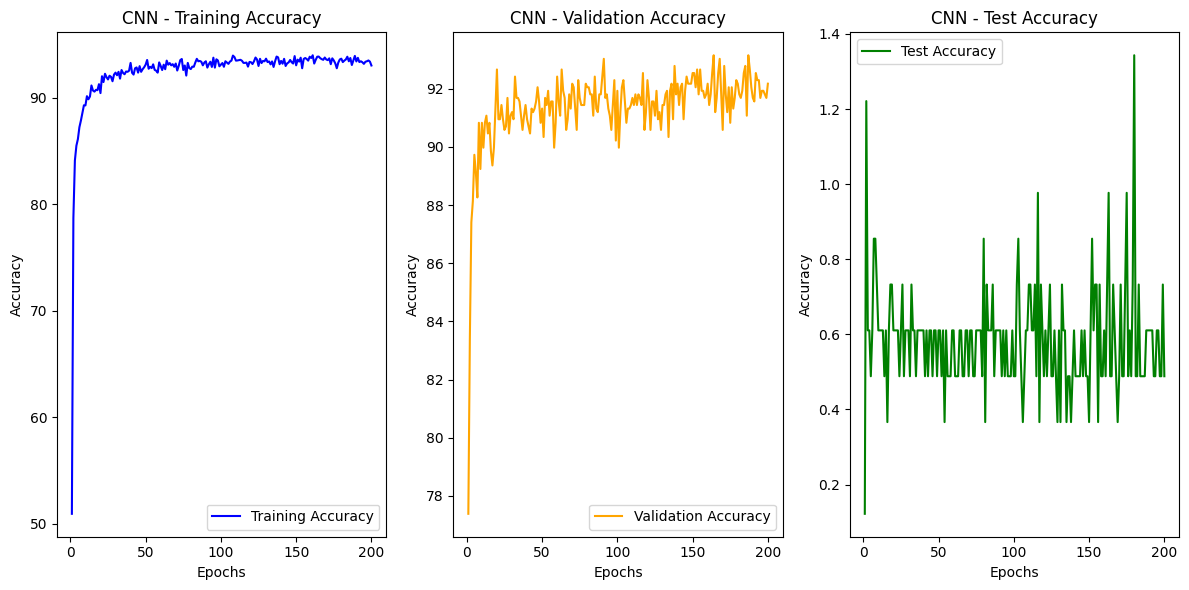

In [ ]:

import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, test_acc, model_name="Model"):
    epochs = len(train_acc)  # Total number of epochs

    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming train_acc_cnn, val_acc_cnn, test_acc_cnn and train_acc_vit, val_acc_vit, test_acc_vit are available



# Plot for ViT
plot_training_history(train_acc_cnn, val_acc_cnn,test_acc_cnn, 'CNN')



In [ ]:
pip install timm

In [ ]:
from timm import create_model
import torch.nn as nn
import torch.optim as optim
# Load ViT model
vit_model = create_model('vit_base_patch16_224', pretrained=True, num_classes=len(train_dataset.classes))

# Freeze all layers except the head
for param in vit_model.parameters():
    param.requires_grad = False

for param in vit_model.head.parameters():
    param.requires_grad = True

# Optimizer and Loss Function
optimizer_vit = optim.AdamW(vit_model.head.parameters(), lr=3e-4, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()

# Train ViT
train_acc_vit, val_acc_vit, test_acc_vit, memory_allocated_history_vit = train_validate_test(
    vit_model, train_loader, valid_loader,test_loader, optimizer_vit, criterion, epochs=13, is_vit=True, threshold=95.0
)



Epoch 1: Memory Allocated: 356.29 MB, Memory Reserved: 762.00 MB
Epoch 1/13: Train Acc: 71.93%, Val Acc: 96.45%, Test Acc: 0.49%, Loss: 337.1634, Time: 129.37s
Threshold of 95.0% reached at epoch 1
Epoch 2: Memory Allocated: 356.29 MB, Memory Reserved: 762.00 MB
Epoch 2/13: Train Acc: 95.31%, Val Acc: 98.78%, Test Acc: 0.49%, Loss: 68.5766, Time: 135.25s
Epoch 3: Memory Allocated: 356.29 MB, Memory Reserved: 762.00 MB
Epoch 3/13: Train Acc: 96.89%, Val Acc: 99.02%, Test Acc: 0.49%, Loss: 42.2585, Time: 135.30s
Epoch 4: Memory Allocated: 356.29 MB, Memory Reserved: 762.00 MB
Epoch 4/13: Train Acc: 97.30%, Val Acc: 98.78%, Test Acc: 0.61%, Loss: 34.4711, Time: 133.68s
Epoch 5: Memory Allocated: 356.29 MB, Memory Reserved: 762.00 MB
Epoch 5/13: Train Acc: 97.39%, Val Acc: 98.78%, Test Acc: 0.61%, Loss: 28.6816, Time: 134.01s
Epoch 6: Memory Allocated: 356.29 MB, Memory Reserved: 762.00 MB
Epoch 6/13: Train Acc: 97.76%, Val Acc: 99.02%, Test Acc: 0.61%, Loss: 23.9876, Time: 133.54s
Epoch 7

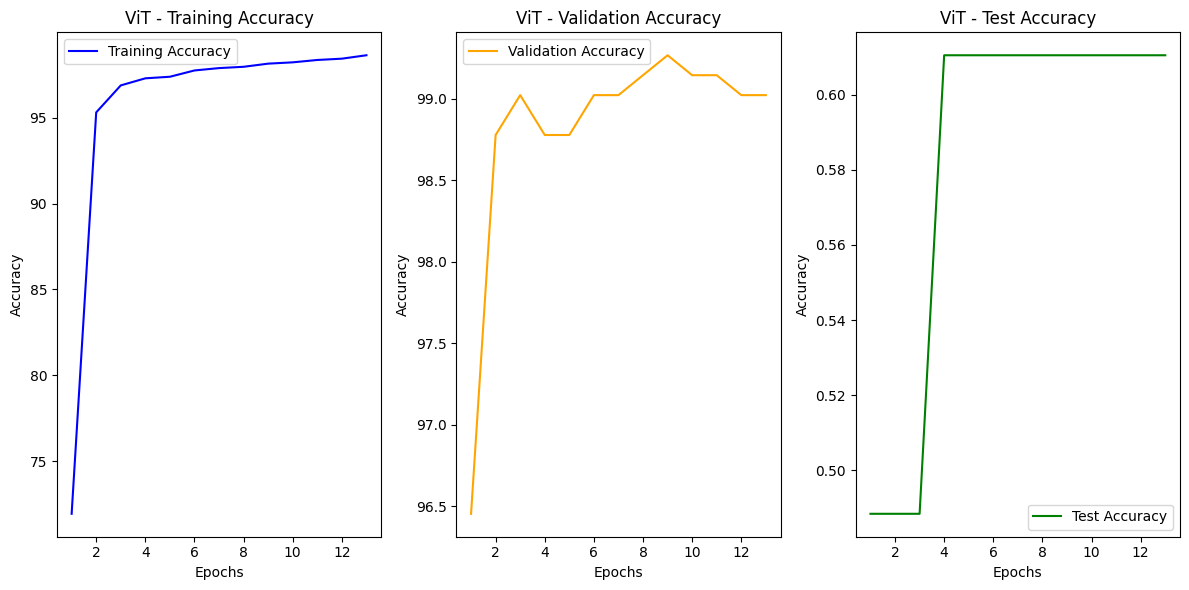

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(train_acc, val_acc, test_acc, model_name="Model"):
    epochs = len(train_acc)  # Total number of epochs

    plt.figure(figsize=(12, 6))

    # Plot Training Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(range(1, epochs + 1), train_acc, label='Training Accuracy', color='blue')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Validation Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(range(1, epochs + 1), val_acc, label='Validation Accuracy', color='orange')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Test Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(range(1, epochs + 1), test_acc, label='Test Accuracy', color='green')
    plt.title(f'{model_name} - Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming train_acc_cnn, val_acc_cnn, test_acc_cnn and train_acc_vit, val_acc_vit, test_acc_vit are available



# Plot for ViT
plot_training_history(train_acc_vit, val_acc_vit,test_acc_vit,'ViT')

